## Исследование данных о российском кинопрокате



Информация о проекте:
- **Заказчик** — Министерство культуры Российской Федерации
- **Цель** - выявить текущие тренды на рынке российского кинопроката.
- **Задачи:**
 - изучить рынок российского кинопроката
 - проанализировать фильмам, которые получили государственную поддержку
 - выяснить насколько такие фильмы интересны зрителю
- **Источник данных** -  портал открытых данных Министерства культуры. Набор данных содержит информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск.

### Шаг 1. Откройте файлы с данными и объедините их в один датафрейм. 

Объедините данные таким образом, чтобы все объекты из датасета `mkrf_movies` обязательно вошли в получившийся датафрейм. 

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_0" aria-expanded="false" aria-controls="collapseHint_0">Подсказка</button>
        </div>
        <div id="collapseHint_0" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Обратите внимание на тип данных столбца, по которому будете соединять датафреймы. Тип данных этих столбцов должен быть одинаковым в обоих датафреймах.
            </div>
        </div>
    </div>
</div>

In [2]:
# Импортируем библиотеки
import pandas as pd # Для работы с данными
import matplotlib.pyplot as plt # Для работы с графиками
import seaborn as sns # Для работы с графиками
import random as rd # Для генерации случайных значений
import numpy as np # Дополнительные функции
import re # Для поиска информации в строках
from pandas.api.types import CategoricalDtype # Для категорий
import copy # Для полного копирования
# для вычисления расстояния Левенштейна
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process
import time # Для замеров длительных операций

In [9]:
import matplotlib as plt
plt.__version__

'3.3.4'

In [2]:
# Получаем данные
mkrf_movies = pd.read_csv('datasets/mkrf_movies.csv')
# Тут дополнительно укажем, что puNumber должен быть строкой, т.к. он изначально int
mkrf_shows = pd.read_csv('datasets/mkrf_shows.csv', dtype={'puNumber': 'object'})

In [3]:
# Объединяем данные в единый дата фрейм
df = mkrf_movies.merge(mkrf_shows, how='left', on='puNumber')
# Выведем количество
len(df)

7486

In [4]:
df.head(3)

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN


Названия столбцов:
- **title** — название фильма;
- **puNumber** — номер прокатного удостоверения;
- **show_start_date** — дата премьеры фильма;
- **type** — тип фильма;
- **film_studio** — студия-производитель;
- **production_country** — страна-производитель;
- **director** — режиссёр;
- **producer** — продюсер;
- **age_restriction** — возрастная категория;
- **refundable_support** — объём возвратных средств государственной поддержки;
- **nonrefundable_support** — объём невозвратных средств государственной поддержки;
- **financing_source** — источник государственного финансирования;
- **budget** — общий бюджет фильма;
- **ratings** — рейтинг фильма на КиноПоиске;
- **genres** — жанр фильма;
- **box_office** — сборы в рублях.

### Шаг 2. Предобработка данных

#### Шаг 2.1. Проверьте типы данных

- Проверьте типы данных в датафрейме и преобразуйте их там, где это необходимо.

In [5]:
# Исходные типы
df.dtypes.to_frame().T

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,object,float64


In [6]:
# В формат даты
df['show_start_date'] = pd.to_datetime(df['show_start_date'], format='%Y-%m-%dT%H:%M:%S.%fZ')

In [7]:
# Создаем упорядоченную категорию по возрасту
age_restriction_order = CategoricalDtype(
    ['«0+» - для любой зрительской аудитории', 
     '«6+» - для детей старше 6 лет', 
     '«12+» - для детей старше 12 лет',
     '«16+» - для детей старше 16 лет',
     '«18+» - запрещено для детей'],
     ordered=True)

# Задаем тип категории
df['age_restriction'] = df['age_restriction'].astype(age_restriction_order)

In [8]:
# Определяем в категорию
df['type'] = df['type'].astype('category')

In [9]:
# Определяем в категорию
df['financing_source'] = df['financing_source'].astype('category')

In [10]:
# Убираем проценты из строк и преобразуем в число
df['ratings'] = df['ratings'].str.replace('%','').astype('float')

In [11]:
# Измененные типы
df.dtypes.to_frame().T

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,object,object,datetime64[ns],category,object,object,object,object,category,float64,float64,float64,category,float64,object,float64


Изменили типы для следующих параметров:
- **show_start_date** – в дату
- **age_restriction** – в категорию с сортировкой
- **type** – в категорию
- **financing_source** – в категорию
- **ratings** – в естественное число

В категории были переведены те столбцы, в которых было мало значений.


Хоть такие столбцы как **production_country** или **film_studio** тоже можно отнести к категориальным, значений там слишком много и записаны они по разному, поэтому использования типа категории в данном случае не оптимально.


#### Шаг 2.2. Изучите пропуски в датафрейме

- Объясните, почему заполнили пропуски определённым образом или почему не стали этого делать.

In [12]:
# Визуализация пропусков
def show_gaps(df):
    ((df.isna().mean()*100)
    .to_frame()
    .rename(columns = {0:'gaps'})
    .query('gaps > 0')
    .sort_values(by = 'gaps', ascending = True)
    .plot(kind= 'barh', figsize=(15,6), legend = False, fontsize = 16, color='orange', xlim=(0,100))
    .set_title('Процент пропусков в таблице', fontsize = 22, color = 'Black'))
    plt.show()

# В виде таблицы   
def show_gaps_tab(df):
    return (df.isna().sum().to_frame().rename(columns = {0:'gaps'}).query('gaps > 0')
        .sort_values(by = 'gaps', ascending = False).T)

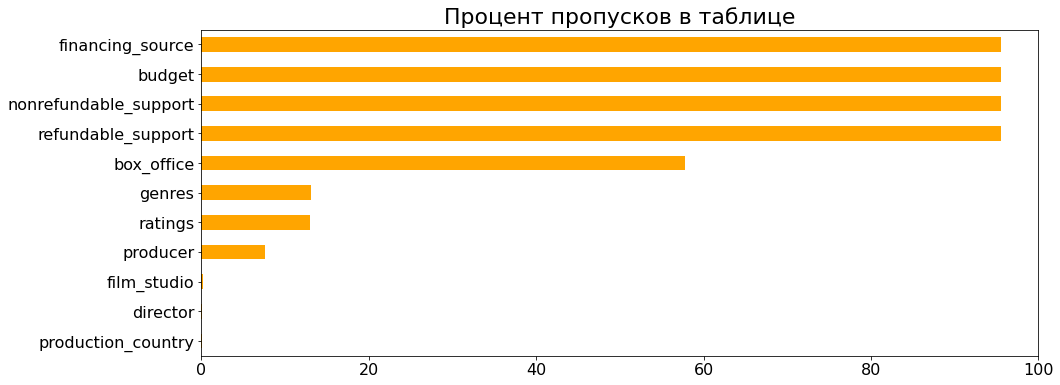

,refundable_support,nonrefundable_support,budget,financing_source,box_office,genres,ratings,producer,film_studio,director,production_country
gaps,7154,7154,7154,7154,4328,976,967,568,18,9,2


In [13]:
show_gaps(df)
show_gaps_tab(df)

In [14]:
# Количество строк по пересечениям пропусков
len(df.query('financing_source.isna() and budget.isna() and refundable_support.isna() and nonrefundable_support.isna()'))

7154

У параметров:
- источник государственного финансирования;
- общий бюджет фильма;
- объём возвратных средств государственной поддержки;
- объём невозвратных средств государственной поддержки.

Пропуски находятся в одинаковых местах и всех и объединяет что страна производитель – Россия.
В некоторых параметрах есть нули, поэтому забивать эти параметры каким-либо значением – лишнее, иначе мы потеряем информацию


У параметра **box_office**(сборы в рублях) пропуски могут быть абсолютно случайными, так и просто могут быть неизвестны:
Для примера, из пропусков в этом столбце был взят фильм «Особо опасен». На КиноПоиске указано что сборы в России составляют 26 млн, хотя тут этой информации нет.

Есть другой фильм – **«Звериная ярость»**. У него на КиноПоиске информация только об общих сборах, а про Российский формат ничего нет.

Получается следующая ситуация:

У нас вперемешку не заполнены фильмы, у которых есть информация, но отсутствует в данной таблице, а есть те, которые не имеют её вообще. Т.к. сборы невозможно вычислить по присутствующим параметрам - заполнить этот столбец никак не получится

Жанр и рейтинг, данные параметры тоже ни с чем не связаны, поэтому оставим пропуски пустыми

Пропуски в столбцах director, film_studio и production_country немногочисленны, их можно заполнить вручную, найдя информацию в интернете. Мы заполним эти параметры только для тех картин, где непустая целевая переменная - box_office

In [15]:
# Ищем картины без студии но со сборами
df.query('film_studio.isna() and not box_office.isna()')

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
6399,Доживем до каникул?..,111021918,2018-11-15 12:00:00,Художественный,NaN,Россия,Я.Хальпукова (псевдоним Яна Мартынец),Я.Хальпукова (псевдоним Яна Мартынец),«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,41225.0


Фильм **"доживём до каникул?"** Действительно не имеет студии, поэтому тут ничего не заполняем

In [16]:
# Ищем картины без страны но со сборами
df.query('production_country.isna() and not box_office.isna()')

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3186,"Детский юмористический киножурнал ""Ералаш. Ну ...",111001216,2016-02-09 12:00:00,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А...","ООО ""Продюсерский центр ЕРАЛАШ""",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.2,"детский,комедия",194527.0


In [17]:
# Меняем страну для фильма
df.loc[df['title'] == 'Детский юмористический киножурнал "Ералаш. Ну просто фантазтика!"', 'production_country'] = 'Россия'

In [18]:
# Ищем картины без режиссёра но со сборами
df.query('director.isna() and not box_office.isna()')

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
764,"Три звезды. Концерт в Waldbuhne Theater, Берли...",126003512,2012-12-04 12:00:00,Прочие,Райзинг Алтернатив,Великобритания,NaN,Вальдбюне Театр,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,44350.0


Это даже не фильм, концерт. Режиссёра найти не удалось, поэтому оставим

In [19]:
# Ищем количество картины без продуюсера но со сборами
len(df.query('producer.isna() and not box_office.isna()'))

116

In [20]:
# Страны картин без режиссёра но со сборами
df.query('producer.isna() and not box_office.isna()').value_counts('production_country').head(3)

production_country
СССР      70
Япония     9
США        5
dtype: int64

Менять 116 записей вручную не будем, тем более, глядя на страны таких картин, видим, что больше всего продюсеров нет у картин из СССР.

Это понятно, потому что деньги тогда выделялись не конкретными лицами, а государством.

Заполнять этот столбец сложным алгоритм нет смысла, т.к. эта переменная не особо нужна в нашем исследовании.

**Вывод:**

Что касается других крупных поисков, заполнять их не будем. Это можно сделать, просматривая каждый фильм в интернете и заполняя его тут, но это будет очень долго и смысла в этом нет. Наше решение будет не универсально и подойдёт только для этого набора данных.

Ставить какое-нибудь значение, по типу «Нет страны», «Нет режиссёра» тоже нет особого смысла. Пропуски могли появиться как случайно, так и просто, где реально нет этого параметра.

Самые многочисленные пропуски в числительных переменных тоже нет смысла заполнять. Любые синтетические данные, которые мы туда подставим, будет подобно гаданию и не отразят реальной картины, а только испортят текущие показатели. Для исследовательского анализа данных данный метод не подходит.
Будем анализировать только то, что есть.


#### Шаг 2.3. Изучите дубликаты в датафрейме
- Проверьте, есть ли в данных дубликаты. Опишите причины, которые могли повлиять на появление дублей.

In [21]:
# Посмотрим на дубликаты в названии фильмов
df['title'].value_counts().to_frame().query('title > 1').head(5).T

,День святого Валентина_,Кошки против собак: Месть Китти Галор,Робин Гуд (Robin Hood),Кошмар на улице Вязов /Фильм ужасов/,Не брать живым /По книге Раджива Чандрасекарана/
title,5,4,4,4,4


In [22]:
# Получим список фильмов которые называются одинаково, но являются разными картинами
# Будем ориентироваться по режиссёру. Вряд ли есть фильмы от одного режиссёра с повторяющимся названием
movies_with_same_title = (df[df['title'].isin(df['title'].value_counts().to_frame()
                                             .query('title > 1').reset_index()['index'])][['title', 'director']]
                                             .drop_duplicates()['title'].value_counts().to_frame()
                                             .query('title > 1').reset_index())
# Посмотрим на 10 таких фильмов
movies_with_same_title.set_index('index').head(10).T

index,Прощание,Успех,Ложные признания,Профессионал,На колесах,Квадрат,Шпион по соседству,"Отель ""Гранд Будапешт""",Зверь,Господин Никто
title,4,3,2,2,2,2,2,2,2,2


Чтобы можно было идентифицировать фильмы с одинаковым названием – мы добавим в скобках имя режиссера в названии

In [23]:
# Сохраним фильмы и режиссеров
movies_producers = df.query('title.isin(@movies_with_same_title["index"])')[['title','director']].drop_duplicates().sort_values(by='title')
movies_producers

,title,director
6674,Большая игра,Б.Батуллин
5671,Большая игра,Аарон Соркин
7450,В тихом омуте,Адам Рэндолл
3394,В тихом омуте,Брюно Дюмон
86,Валентина,Г.Панфилов
6899,Валентина,Д.Былинушкина
5430,Вторжение,Эрик Дарнелл
7474,Вторжение,Ф.Бондарчук
6677,Город грехов,"Фрэнк Миллер, Роберт Родригес, Квентин Тарантино"
4650,Город грехов,"Фрэнк Миллер, Роберт Родригес"


Есть строки, где авторы просто написаны по-разному, но фильм один и тот-же. Просто исключим такие строки из выборки

In [24]:
# Добавим во фрейм записи исключения
except_mov = pd.DataFrame([
    {'title':'Город грехов', 'director':'Фрэнк Миллер, Роберт Родригес, Квентин Тарантино'},
    {'title':'Город грехов', 'director':'Фрэнк Миллер, Роберт Родригес'},
    {'title':'Господин Никто', 'director':'Жако Ван Дормель'},
    {'title':'Господин Никто', 'director':'Жако ван Дормель'},
    {'title':'Клык', 'director':'Йоргос Лантимос'},
    {'title':'Клык', 'director':'Гиоргос Лантимос'},
    {'title':'Морская бригада', 'director':'Го Аун Хое'},
    {'title':'Морская бригада', 'director':'Аун Хое Го'},
    {'title':'Отель "Гранд Будапешт"', 'director':'Уэс Андерсен'},
    {'title':'Отель "Гранд Будапешт"', 'director':'Уэс Андерсон'}
])

# Сохраняем список
movies_producers = (movies_producers.merge(except_mov, on=['title', 'director'], how="outer", indicator=True)
                    .query('_merge == "left_only"'))[['title', 'director']]

In [25]:
# Формируем новое название
movies_producers['new_title'] = movies_producers['title'] + ' (' + movies_producers['director'] + ')'
movies_producers.head(2)

,title,director,new_title
0,Большая игра,Б.Батуллин,Большая игра (Б.Батуллин)
1,Большая игра,Аарон Соркин,Большая игра (Аарон Соркин)


In [26]:
# Сохраняем объединение в отдельную переменную
new_titles = df.merge(movies_producers, on=['title', 'director'], how='left').query('~new_title.isna()')['new_title']

# Загружаем данные в исходную таблицу
df.loc[new_titles.index, 'title'] = new_titles

Мы разграничили фильмы с одинаковыми названиями, но дубли по-прежнему присутствуют.
Есть строки, которые имеют одинаковые названия, разные прокатные удостоверения и разные даты.
Скорее всего это разные даты показа. Чтобы избавиться от таких дублей, возьмем самую первую дату и информацию по фильмам и посчитаем общую сумму сборов

Рассмотрев фильм, который повторяется чаще всего, было выявлено, что у данных строк отличаются только поля **puNumber** и **show_start_date**. Посмотрим на них:

In [27]:
df[df['title'].str.contains('День святого Валентина')].head(3)

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3902,День святого Валентина_,221083810,2010-07-15 12:00:00,Художественный,"Уорнер Бразерс, Нью Лайн Синема, Уэйн Райс, Ка...",США,Гарри Маршалл,Сэмюэл Дж.Браун,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,6.7,"мелодрама,комедия",NaN
3991,День святого Валентина_,221068010,2010-05-14 12:00:00,Художественный,"Уорнер Бразерс, Нью Лайн Синема, Уэйн Райс, Ка...",США,Гарри Маршалл,Сэмюэл Дж.Браун,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,6.7,"мелодрама,комедия",NaN
4070,День святого Валентина_,121002210,2010-02-03 12:00:00,Художественный,"Уорнер Бразерс, Нью Лайн Синема, Уэйн Райс, Ка...",США,Гарри Маршалл,Сэмюэл Дж.Браун,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,6.7,"мелодрама,комедия",NaN


In [28]:
# Пометим в таблице фильмы, у которых есть неявные дубликаты
df['have_duplicates'] = False
df.loc[df['title'].isin(df['title'].value_counts().to_frame().query('title > 1').index), 'have_duplicates'] = True

In [29]:
# Помечаем первую дату
df['first_date'] = (df.merge(df.groupby('title')['show_start_date'].min().to_frame().reset_index(), 
         on=['title', 'show_start_date'], how='outer', indicator=True)
                    [['title', 'show_start_date', '_merge']].drop_duplicates()['_merge'])

In [30]:
# Загружаем сумму проката
df.loc[(df['first_date'] == 'both') & (df['have_duplicates']), 'box_office'] = df.merge(
                            df.groupby('title')['box_office'].sum().to_frame(), on='title', how='left')['box_office_y']

In [31]:
# Удаляем дубли
df = df[~((df['have_duplicates']) & (df['first_date'] != 'both'))].reset_index(drop=True)

In [32]:
# Проверим дубликаты номеров
df['puNumber'].value_counts().to_frame().query('puNumber > 1')

,puNumber
221054410,2


In [33]:
df[df['puNumber'] == '221054410']

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,have_duplicates,first_date
4457,Анализируй это!,221054410,2010-05-25 12:00:00,Художественный,"Уорнер Бразерс, Вилладж Роудшоу Филмз ЛТД",США-Австралия,ХЭрольд Рэмис,"Джейн Розенталь, Пола Уейнстейн",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.4,"комедия,криминал",0.0,True,both
4458,Анализируй то!,221054410,2010-05-25 12:00:00,Художественный,"Уорнер Бразерс, Виллидж Роадшоу Пикчерз, Эн-Пи...",США,Гарольд Реймис,"Джейн Розенталь, Паул Уэйнстейн",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,6.8,"комедия,криминал",NaN,False,both


В данных строках нет нужной нам информации, они почти полностью пустые, поэтому просто выкинем их

In [34]:
df = df[df['puNumber'] != '221054410'].reset_index(drop=True)

Таким образом мы устранили дубликаты фильмов

In [35]:
len(df)

6796

**Вывод:**
В таблице были неявные дубликаты. Такие дубли имели одинаковые параметры, но отличалась дата премьеры фильмы. Скорее всего, имелась ввиду премьера в разных странах.

Были также и фильмы одинаковым названием, но являющимися разными картинами.
От данных дубликатов мы избавились следующим способом:

- Названия фильмов сделали различными – приписали имя режиссёра в скобках у тех фильмов, у которых есть схожие название
- Взяли записи с самыми ранними показами – что, по сути, и является главной премьерой. Сборы заполнили общей суммой со всех прокатов

Встречались также записи с одинаковыми номерами. Их было очень мало и множество параметров в них были пустыми, поэтому мы их просто удалили из выборки


#### Шаг 2.4. Изучите категориальные значения

- Посмотрите, какая общая проблема встречается почти во всех категориальных столбцах;
- Исправьте проблемные значения в поле `type`.

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_1" aria-expanded="false" aria-controls="collapseHint_1">Подсказка</button>
        </div>
        <div id="collapseHint_1" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
В поле <code>type</code> есть несколько значений, у которых появился пробел в начале строки. Самый простой способ их «починить» -- использовать метод <a href="https://pandas.pydata.org/docs/reference/api/pandas.Series.str.strip.html#pandas.Series.str.strip">.str.strip</a>. Этот метод удаляет все пробелы, которые встречаются в начале и в конце строки. Применяют его таким образом:<br>
<code>df['type'].str.strip()</code>
            </div>
        </div>
    </div>
</div>

In [36]:
# Удаляем пробелы
df['type'] = df['type'].str.strip()
# Определяем в категорию
df['type'] = df['type'].astype('category')

In [37]:
# Смотрим на значения
df['type'].value_counts()

Художественный                5297
Анимационный                   770
Прочие                         393
Документальный                 283
Научно-популярный               52
Музыкально-развлекательный       1
Name: type, dtype: int64

Изучим прокатное удостоверение. Судя по всему, код состоит только из чисел и имеет 9 знаков. Создадим фильтр, который покажет не подходящие под это условие

In [38]:
df.query('(not puNumber.str.contains(r"^\d{9}$"))')

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,have_duplicates,first_date
630,Паранормальный Якутск,111004112,2012-08-24 12:00:00,Художественный,ИП Тимофеев К.П.,Россия,К.Тимофеев,NaN,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,both
1530,Курбан-роман. (История с жертвой),нет,2014-05-15 12:00:00,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,both
4175,1001 рецепт влюбленного кулинара,1811096,2010-12-23 12:00:00,Художественный,"Ле Фильм дю Риваж, Ля Сет Синема, Адам и Ева, ...",Франция-Грузия-Германия-Россия-Украина-Бельгия,Н.Джорджадзе,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,6.7,"мелодрама,комедия",NaN,False,both


Всего 3 строки у которых нет никакой информации. Просто удалим их

In [39]:
df = (df.query('not ((not puNumber.str.contains(r"^\d{9}$")))')
     .reset_index(drop=True))

In [40]:
# Сколько было уникальных
print('Было:', len(df['film_studio'].unique()))

# Удаляем пробелы из названий студий
df['film_studio'] = df['film_studio'].str.strip()

# Сколько стало
print('Стало:', len(df['film_studio'].unique()))

Было: 5467
Стало: 5440


In [41]:
# Если привести к нижнему регистру
print('Если все в нижнем регистре:', len(df['film_studio'].str.lower().unique()))

Если все в нижнем регистре: 5401


In [42]:
# Создаем столбце с названиями в нижнем регистре
df['film_studio_lower'] = df['film_studio'].str.lower()

# Заменяем строки
df['film_studio'] = df.merge(df[~df['film_studio'].isna()]
            .groupby('film_studio_lower')['film_studio'].agg(['first']).reset_index(),
            how='left', on='film_studio_lower')['first']

# Удаляем вспомогательный стобец
df = df.drop('film_studio_lower', axis=1)

Поработаем со столбцом названия студий. Ранее в исследовании было замечено, что в нем есть неявные дубли:

In [43]:
film_studios = pd.DataFrame({'film_studio':df['film_studio'].unique()}).dropna()

In [44]:
film_studios['len'] = film_studios['film_studio'].str.len()

Изучим, какие типы записей встречаются

In [45]:
film_studios.sort_values(by='len', ascending=False).head(2)

,film_studio,len
843,"Арсам Интернэшнл, Дибона Филмз, Энтр Шьен э Лу...",255
696,"Диалог Фильм, А Эр Пэ Селекцион, Нумеро 4 Прод...",255


Есть строки, где указано множество названий. Тут названия можно просто разбить запятыми

In [46]:
film_studios[film_studios['film_studio'].str.contains('"')].head(3)

,film_studio,len
1,"Киностудия ""Мосфильм""",21
5,"Киностудия ""Мосфильм"", Телевидение ВНР",38
23,"АО ""Караван"", Компания ""Америкен Дистрибьюшн"",...",102


Есть строки, где названия указаны в кавычках. В таком случае, если в строке они есть, будем брать информацию из них

In [47]:
film_studios[film_studios['film_studio'].str.contains('\(')].head(3)

,film_studio,len
25,"Киностудия ""Мосфильм"", ""Про Дис Фильм"" АГ Цюри...",56
26,"совместное производство Киностудия ""Мосфильм"",...",138
29,"Киностудия ""Мосфильм"", ""Баррандов"" (ЧССР) при...",128


В круглых скобках, обычно указывают название стран, либо авторов. Эту информацию можно отчистить, т.к. нам нужны только названия

Помимо запятых, в названиях также встречаются “по заказу”, “при участии”. Эти фразы тоже можно считать разделителями

Получается такой алгоритм, по извлечению названий из строки:
1.	Разобьём строку на отдельные элементы, через запятую и фраз, по типу “при участии”
2.	Уберем информацию в круглых скобках, в которой, как правило, написаны имена авторов и страны
3.	Если в получившихся подстроках есть Кавычки, то возьмем название из них, остальное отбросим

С кавычками дела обстоят сложнее, нельзя просто взять информацию из кавычек.

Например, для таких видов строк это сработает:
- **Вход:** "Баррандов" (ЧССР) при участии "Альянс Фильмопродукцион ГМБХ"
- **Выход:** [“Баррандов”, “Альянс Фильмопродукцион ГМБХ”]

А вот для таких строк будут проблемы:
- **Вход:** ООО" Студия "ТРИТЭ" Никиты Михалкова"
- **Выход:** [" Студия”, “" Никиты Михалкова"”]

Результат неправильный. В данном случае, нам нужно было-бы получить:
- " Студия "ТРИТЭ" Никиты Михалкова"

Как это реализовать регулярными выражениями, я не знаю, возможно есть способ, но моего уровня для его реализации не хватит, поэтому сделаем через функцию с условиями

In [48]:
# Извлечение названий из кавычек
def sep_parts_text_quotation(text, spaces=' -'):
    split_text = text.split('"')
    result = []
    current_phras = ''
    join_words = False
    # защита от пробела в начале
    first = True
    for text in split_text[1:-1]:
        if len(text) == 0:
            if join_words:
                join_words = False
                current_phras += text
                result.append(current_phras)
                current_phras = ''
        elif text[0] in spaces and text[-1] in spaces:
            if first:
                join_words = True
                current_phras += text
            else:
                current_phras += text if join_words else ''
        elif text[-1] in spaces:
            join_words = True
            current_phras += text
        elif text[0] in spaces:
            if first:
                join_words = True
                current_phras += text
            else:
                join_words = False
                current_phras += text
                result.append(current_phras)
                current_phras = ''
        else:
            if join_words:
                current_phras += f'"{text}"'
            else:
                result.append(text)
        first = False
    return result

In [49]:
# Извлечение отдельных названий из всей строки
def find_names_text(text, separators=[]):
    prep_text = text
    for sep_f in separators:
        prep_text = re.sub(sep_f, ',', prep_text)
    prep_text = re.sub(r'\(.+?\)', '', prep_text)    
    sep_text = prep_text.split(',')
    for i in range(len(sep_text)):
        if re.search(r'^(?=.+?".+").+', sep_text[i]) != None:
            brackets_only = re.search(r'\".+\"', sep_text[i])[0]
            from_quotes = sep_parts_text_quotation(brackets_only)
            if len(from_quotes) == 0:
                continue
            sep_text[i] = from_quotes[0]
            if len(from_quotes) > 1:
                for j in from_quotes[1:]:
                    sep_text.append(j)
            
    sep_text = [re.sub(r'^"|"$', '', se_te).strip() for se_te in sep_text if len(se_te.strip()) != 0]
    return sep_text

Проверим функцию на примерах, о которых писали выше

In [50]:
print(find_names_text('"Баррандов" (ЧССР) при участии "Альянс Фильмопродукцион ГМБХ"'))
print(find_names_text('" Студия "ТРИТЭ" Никиты Михалкова"'))
print(find_names_text('"Америкен Дистрибьюшн" Роскомкино киностудия "Курьер" киноконцерна "Мосфильм"'))
print(find_names_text('" Роскомкино киностудия "Курьер"" киноконцерна "Мосфильм" и " Роскомкино киностудия "Курьер""'))

['Баррандов', 'Альянс Фильмопродукцион ГМБХ']
['Студия "ТРИТЭ" Никиты Михалкова']
['Америкен Дистрибьюшн', 'Курьер', 'Мосфильм']
['Роскомкино киностудия "Курьер', 'Мосфильм', 'Курьер']


Функция работает корректно. Применим её ко всем значениям:

In [51]:
# Формируем список слов разделителей
sep_phrases = ['при участии', 'по заказу', ';']

In [52]:
# Применяем функцию к столбцу названий
film_studios['separate_studios'] = film_studios['film_studio'].apply(find_names_text, args=([sep_phrases]))

In [53]:
film_studios

,film_studio,len,separate_studios
0,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",63,"[Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикч..."
1,"Киностудия ""Мосфильм""",21,[Мосфильм]
2,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",137,"[Юниверсал Пикчерз, Кикстарт Продакшнз, Марк П..."
3,"Юнайтед Артистс, Грин Стрит Филмз, Айкон Интер...",65,"[Юнайтед Артистс, Грин Стрит Филмз, Айкон Инте..."
4,"Пульсар Продюксьон, ТФ1 Фильм",29,"[Пульсар Продюксьон, ТФ1 Фильм]"
...,...,...,...
5396,Свон Филмз,10,[Свон Филмз]
5397,Севен Артс Продакшнз,20,[Севен Артс Продакшнз]
5398,"Дэниел Гродник Продакшнз, Вандерфилм Медиа Кор...",110,"[Дэниел Гродник Продакшнз, Вандерфилм Медиа Ко..."
5399,"Никелодеон Анимейшн Студиос, Спин Мастер",40,"[Никелодеон Анимейшн Студиос, Спин Мастер]"


In [54]:
# Сохраним все названия студий в отдельный датафрейм
sep_names = pd.DataFrame({'film_studio_solo':film_studios['separate_studios'].sum()})

In [55]:
# Выведем 10 самых встречающихся студий
sep_names['film_studio_solo'].value_counts().head(10)

Уорнер Бразерс       280
Канал +              219
Сине +               137
Юниверсал Пикчерз    135
ХХ век Фокс          101
Франс Телевизьон      89
Парамаунт Пикчерз     85
Коламбиа Пикчерз      83
Франс 2 Синема        82
Нью Лайн Синема       80
Name: film_studio_solo, dtype: int64

Топ 10 студий, которых больше всего в данном датасете, но данные могут измениться, потому что в таблице присутствуют неявные дубликаты – названия, которые обозначают одну студию но пишутся немного по разному. Постараемся снизить количество таких дублей с помощью нечеткого сравнения

In [56]:
# Удалим явные дубли и отсортируем имена по алфавиту
sep_names = sep_names.drop_duplicates().sort_values(by='film_studio_solo')
len(sep_names)

10562

Мы собираемся провести нечеткое сравнение для каждой строки, получается нам придется сравнить каждое значение со всеми остальными. У нас 10к записей, получается необходимо будет произвести 100 млн операций нечеткого сравнения. Такая обработка займет очень много времени, для этого было проведено исследование скорости выполненные данной операции. Время обработки двух строк занимает всего 0,00007 сек, но для 100 млн записей это будет более двух часов.

Это можно было организовать и обработать все строки, но в рамках проекта, где каждый раз нужно перегружать ячейки такое решение не подходит, поэтому постараемся немного ускорить эту проверку:

In [6]:
# Функция для разделения массива
def split_array_n(a, n):
    '''
    Делит список на заданное количество частей. Возвращает список списков с заданным количеством
            Параметры:
                    a (list): список, который нужно разбить
                    n (int): количество групп, на которое следует разбить список.
            Возвращаемое значение:
                    result (list): список списков
    '''
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

# Функция для разделения словаря
def split_dict_n(a, n):
    '''
    Делит словарь на заданное количество частей. Возвращает список словарей с заданным количеством
            Параметры:
                    a (dict): словарь, который нужно разбить
                    n (int): количество групп, на которое следует разбить словарь.
            Возвращаемое значение:
                    result (list): список словарей
    '''
    k = round(len(a)/ n)
    i = 0
    result = []
    current_set = {}
    if k == 0:
        result.append(a)
        return result
    for key, value in a.items():
        current_set[key] = value
        if (i != 0) and ((i+1) % k == 0):
            result.append(current_set)
            current_set = {}
        i += 1
    if len(current_set) > 0:
        result.append(current_set)
    return result

In [7]:
def find_similar_by_parts(dictionary, count_group=0, sem_limit=85, print_num_op=False):
    '''
    Ищет схожие ключи(названия) и помещает их в список к искомому ключу, 
    а также удаляет их из списка. Возвращает новый уменьшенный словарь с найденными схожими названиями.
            Параметры:
                    dictionary (dict): словарь списков. Каждый ключ соответствует имени, а значение – список схожих названий
                    count_group (int): количество групп, на которое следует разбить словарь.
                        Чем меньше по размеру будут группы, тем быстрее будет поверка, 
                        но тем менее обширной она будет. Стоит делить словарь, 
                        если размер словаря больше 1000
                    sem_limit (int): Порог схожести слов. Чем он ниже, тем больше слов попадут в массив слов, чем выше, 
                        тем меньше, но результат будет более правильный
                    print_num_op (bool): выводить информацию о количестве произведённых операций     
            Возвращаемое значение:
                    result (dict): словарь с такой-же структурой как изначально, 
                        но, возможно немного короче и с некоторыми вхождениями в массивы
    '''
    number_operations = 0
    if count_group == 0 or count_group >= len(dictionary):
        name_list_parts = [copy.deepcopy(dictionary)]
    else:
        # Разбиваем словарь на n частей
        name_list_parts = split_dict_n(copy.deepcopy(dictionary), count_group)

    for part in name_list_parts:

        # Список названий не требующих проверку
        not_require_verif = []
        # список на удаление
        for_deletion = [] 

        for word, sim in part.items():
            # Пропускам слово, если оно уже нашло сопоставление    
            if word in not_require_verif:
                continue
            
            # храним найденные слова
            similar_words = []

            # Исключаем текущее слово из выборки  
            not_require_verif.append(word)

            # Убираем из списка слова, которые уже проверены 
            search_list = [wrd for wrd in part if wrd not in not_require_verif]

            # Сравнения слов со спписком
            for contrast_word in search_list:
                number_operations += 1
                percent_similar = fuzz.WRatio(word, contrast_word)
                if percent_similar >= sem_limit:
                    not_require_verif.append(contrast_word)
                    for_deletion.append(contrast_word)
                    sim.append(contrast_word)

            # Сохранение результата
            part[word] = sim

        # удаляем из словаря дубли
        for del_key in for_deletion:
            part.pop(del_key)
            
    result = {}
    for di in name_list_parts:
        result = result | di
    if print_num_op:
        print('операций:', number_operations)    
    return result

In [4]:
help(find_similar_by_parts)

Help on function find_similar_by_parts in module __main__:

find_similar_by_parts(dictionary, count_group=0, sem_limit=85, print_num_op=False)
    Ищет схожие ключи(названия) и помещает их в список к искомому ключу, 
    а также удаляет их из списка. Возвращает новый уменьшенный словарь с найденными схожими названиями.
            Параметры:
                    dictionary (dict): словарь списков. Каждый ключ соответствует имени, а значение – список схожих названий
                    count_group (int): количество групп, на которое следует разбить словарь.
                        Чем меньше по размеру будут группы, тем быстрее будет поверка, 
                        но тем менее обширной она будет. Стоит делить словарь, 
                        если размер словаря больше 1000
                    sem_limit (int): Порог схожести слов. Чем он ниже, тем больше слов попадут в массив слов, чем выше, 
                        тем меньше, но результат будет более правильный
                    p

In [59]:
# Функция для преобразования массива в нужную структуру для работы
def convert_to_dict_list(source_list):
    return {part:[] for part in source_list}

**Пример работы функции:** у нас есть словарь с 12 вариантами приветствий

In [60]:
greetings = {'привет':[],'Привет':[],'прив ет':[]
             ,'прив':[],'здравствуйте':[],'ну здравствуй':[]
             ,'хай':[],'прива':[],'здрасте':[]
             ,'хэй':[],'хелло':[],'приветствую':[]}

Пример маленький и можно обработать его сразу весь, но для демонстрации будем делить этот словарь на 4 группы.

Происходит такой алгоритм:
1.	В каждой группе, каждый элемент сравнивается с другими в своей группе
2.	Если находится элемент с процентом схожести равной или более заданной нами, то этот элемент добавляется в список текущего ключа словаря и удаляется из общего списка, чтобы не проверяться при следующей итерации
3.	В итоге имеем список, где более схожие значения помещены в массивы другого элемента, а сам список уменьшен


In [61]:
# Делаем первую итерацию поиска схожих
greetings2 = find_similar_by_parts(greetings, 4, 75)
greetings2

{'привет': ['Привет', 'прив ет'],
 'прив': [],
 'здравствуйте': ['ну здравствуй'],
 'хай': [],
 'прива': [],
 'здрасте': [],
 'хэй': [],
 'хелло': [],
 'приветствую': []}

Как видно, изначально у нас было **12** элементов, а теперь **9**. Словарь уменьшился, значит при следующем повторе группы будут включать в себя новые элементы и появится шанс найти новые  соответствия

In [62]:
# Делаем вторую итерацию поиска схожих
greetings3 = find_similar_by_parts(greetings2, 3, 50)
greetings3

{'привет': ['Привет', 'прив ет', 'прив'],
 'здравствуйте': ['ну здравствуй'],
 'хай': [],
 'прива': [],
 'здрасте': [],
 'хэй': [],
 'хелло': [],
 'приветствую': []}

Предположим, что мы сократили выборку для такой степени, что мы сможем обработать её без разделения на группы:

In [63]:
# Делаем третью итерацию поиска схожих
greetings4 = find_similar_by_parts(greetings3, 1, 50)
greetings4

{'привет': ['Привет', 'прив ет', 'прив', 'прива', 'приветствую'],
 'здравствуйте': ['ну здравствуй', 'здрасте'],
 'хай': ['хэй'],
 'хелло': []}

В итоге имеем такой результат. Применим на настоящих данных:

In [64]:
name_list_parts = convert_to_dict_list(sep_names['film_studio_solo'].values)

# Фиксируем начальную длину словаря
f_len = len(name_list_parts)
f_len

10562

<div class="alert alert-warning", style="border:solid red 3px; padding: 20px">
<font size="4", color = "red"><b>⚠️ Внимание – долгое выполнение ячейки ниже – около 5 минут</b></font>
    <br /> 
    <font size="3", color = "black">

In [65]:
def time_convert(sec):
    mins = sec // 60
    sec = round(sec % 60)
    hours = mins // 60
    mins = mins % 60
    print("Прошло времени = {0}:{1}:{2}".format(int(hours),int(mins),sec))

In [66]:
# !!!!!!!!!!!!!!!!!
# Если не нужен данный шаг, просто закомментируете эту ячейку, т.к. он выполняется около 5х минут

# Создаем словарь из имен и пустых списков
# start_time = time.time()
# name_list_parts = convert_to_dict_list(sep_names['film_studio_solo'].values)
# name_list_parts = find_similar_by_parts(name_list_parts, 50, 87, True)
# end_time = time.time()
# time_convert(end_time - start_time)

In [67]:
# Фиксируем длину после обработки
s_len = len(name_list_parts)
f_len - s_len

0

В итоге, за 5 минут мы избавились от 2.5 тыс. неявных дублей. Если мы захотим увеличить это число, то понадобится больше времени

Понимаю, что в таблице наверняка есть ошибочные сопоставления, устранены не все неявные дубли, но была попытка автоматизировать этот процесс всеми возможными способами.

В интернете много статей с использованием данной библиотеки, но нигде не приведено примера, когда в базе около 10 тыс. таких значений, все примеры, которые я видел, рассматривали небольшие таблицы, до 500 значений, которые можно было бы просмотреть вручную.

Решать эту проблему с неявными дублями и ошибками в выборке, нужно на этапе сбора информации, чтобы нельзя было внести некорректные названия.

Демонстрация результата обработки. Найдем строки начинающиеся с Яш:

In [68]:
pd.Series(name_list_parts).to_frame().reset_index().query('index.str.contains(r"^[яЯ]ш")')

,index,0
10541,Яш Радж Филмз,[]
10542,Яш Радж Фильм,[]
10543,Яш Радж Фильмс,[]
10544,Яш Раи Фильм,[]
10545,Яш Рай Филмз,[]
10546,Яш Рай Фильм,[]


Как видно, есть строки, которые не объединились, возможно это связано со слишком высоким порогом схожести, который мы установили в 85 процентов. Может быть также что эти записи не попали в общую группу.

В любом случае, на устранение таких дублей нужно намного больше времени. Сохраним получившийся результат в исходную таблицу

In [69]:
# Функция которая проходит по каждому списку найденных совпадений,
# находит эти имена в списке другого фрейма данных и меняет на единое название
def replace_names(row, replacement_table, target_column):
    change = False
    for current_name in row['sim_nanes']:
        replacement_table.loc[replacement_table[target_column].apply(lambda x: current_name in x), target_column] = (
                replacement_table[replacement_table[target_column].apply(lambda x: current_name in x)]
                     [target_column].apply(lambda x: list(map(lambda y: y.replace(current_name, row['source_name']), x))))
        change = True
    return change

<div class="alert alert-warning", style="border:solid red 3px; padding: 20px">
<font size="4", color = "red"><b>⚠️ Внимание – долгое выполнение ячейки ниже – около 11 секунд</b></font>
    <br /> 
    <font size="3", color = "black">

In [70]:
# Создадим столбец, в котором будем заменять исходные названия на схожие
film_studios['separate_studios_unification'] = film_studios['separate_studios']

# Преобразуем словарь в дата фрейм
name_list_parts_series = pd.Series(name_list_parts).to_frame().reset_index().rename(columns={'index':'source_name',0:'sim_nanes'})

# Применяем функцию к фрейму с названиями
name_list_parts_series.apply(replace_names, args=(film_studios, 'separate_studios_unification'), axis=1)

# преобразуем в строку
film_studios['separate_studios_unification'] = film_studios['separate_studios_unification'].apply(lambda x: ', '.join(x))

In [71]:
df['film_studio_sep'] = df.merge(film_studios, on='film_studio', how='left')['separate_studios_unification']

In [72]:
# Топ 5 студий в данном фрейме
df.groupby('film_studio_sep')['film_studio'].agg(['first', 'count']).sort_values(by='count', ascending=False).head(5)

,first,count
film_studio_sep,,
Мосфильм,"Киностудия ""Мосфильм""",344
Мульт в кино,"ООО ""Мульт в кино""",75
Анимаккорд Лтд,Анимаккорд Лтд,23
ТаББаК,"ООО ""ТаББаК""",19
"ФГУП ""ТПО ""Киностудия ""Союзмультфильм","ФГУП ""ТПО ""Киностудия ""Союзмультфильм""",16


Как видим, данные отличаются от того топ 10, который мы делали ранее, но это объяснимо. В прошлом топе мы разделили все киностудии на отдельные и смотрели на результаты, в том числе и в совместных проектах, а тут мы видим конкретные связки студий у которых больше всего фильмов

Пока закончим с неявным сравнением и посмотрим остальные столбцы. С другими категориями поступим проще – удалим пробелы с лева и справа, преобразуем в нижний и объединим.

Чтобы не повторять однотипные действия каждый раз, напишем функцию для этого:

In [73]:
def easy_category_cleaning(source_table, column, print_info=True):
    table = source_table.copy()
    if print_info:
        print('Было:', len(table[column].unique()))
    # Удаляем пробелы с двух сторон
    table[column] = table[column].str.strip()
    
    # Создаем временный столбец с названиями в нижнем регистре
    table['_interim_low'] = table[column].str.lower()
    # Заменяем строки
    table[column] = table.merge(table[~table[column].isna()]
        .groupby('_interim_low')[column].agg(['first']).reset_index(),
        how='left', on='_interim_low')['first']
    # Удаляем вспомогательный стобец
    table = table.drop('_interim_low', axis=1)
    if print_info:
        print('Стало:', len(table[column].unique()))
    return table

In [74]:
# Проверим столбец film_studio
easy_category_cleaning(df, 'film_studio')
pass

Было: 5401
Стало: 5401


С данным столбцом мы работали довольно долго и исправили множество проблем. Неудивительно что тут нет проблем с пробелам в начале и конце, а также разным регистром

In [75]:
# Почистим столбец title
df = easy_category_cleaning(df, 'title')

Было: 6793
Стало: 6784


In [76]:
# Почистим столбец producer
df = easy_category_cleaning(df, 'producer')

Было: 5331
Стало: 5309


In [77]:
df = easy_category_cleaning(df, 'director')

Было: 4807
Стало: 4792


In [78]:
df = easy_category_cleaning(df, 'genres')

Было: 743
Стало: 743


**Вывод:**
В столбцах с категориальными значениями было множество дублей и часть до сих пор остается. Причина, по которой они есть – это человеческий фактор.

Например, названия киностудий внесены как-попало. Одна и таже студия может быть написана в 10 вариантах. Где-то присутствуют ошибки по типу незакрытых скобок, пробелов в начале и конце, неправильные регистры.

Каки-то вещи было легко поправить, например, как с пробелами и регистрами, но, чтобы избавиться от по-разному написанных названий пришлось применить расстояние Левенштейна, чтобы провести нечеткое сравнение.

Мы разбили данные, обработали и заново собрали.

Это была очень трудоемкая и долгая часть проекта, для реализации такого алгоритма, пришлось изучить много разных статей о нечетком сравнении, пришлось выучить регулярные выражения и множество других вспомогательных вещей.
Не сказать, что я полностью доволен результатом, т.к. не удалось реализовать все задуманное, т.к. проект необходимо сдавать до дедлайна.

Способ с нечетким сравнением хоть и интересен, но не идеален, приходится его долго настраивать для каждого конкретного случая, проверять обработанные данные вручную, но главная проблема в том, что обработка занимает очень много времени, поэтому было принято решение отказаться от аналогичной обработки для других столбцов.


#### Шаг 2.5. Проверьте количественные значения

- Проверьте, обнаружились ли в таких столбцах подозрительные данные. Как с такими данными лучше поступить?

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_budget" aria-expanded="false" aria-controls="collapseHint_budget">Подсказка</button>
        </div>
        <div id="collapseHint_budget" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Обратите внимание на описание столбца <code>budget</code>. Как этот столбец соотносится с двумя другими: <code>refundable_support</code> и <code>nonrefundable_support</code>?
            </div>
        </div>
    </div>
</div>

In [79]:
df[['refundable_support', 'nonrefundable_support', 'budget', 'box_office', 'ratings']].describe().style.format("{:,.0f}")

,refundable_support,nonrefundable_support,budget,box_office,ratings
count,331,331,331,"3,486","5,836"
mean,"11,900,302","49,038,333","127,469,081","69,282,766",7
std,"24,945,705","60,061,813","188,823,341","229,850,368",6
min,0,0,0,0,1
25%,0,"25,000,000","42,000,000","10,179",6
50%,0,"30,000,000","68,809,226","1,535,034",7
75%,"15,000,000","40,750,000","143,945,639","18,568,330",7
max,"180,000,000","400,000,000","2,305,074,303","3,073,568,691",99


Как видно из описательной статистики, у параметров бюджет, объём возвратных и невозвратных средств государственной поддержки имеют одинаковое количество. Как мы выяснили еще на шаге обработки пропусков, эти данные либо все заполнены в одних строках, либо нигде. Поэтому будем ориентироваться на них.

В данном случае бросаются в глаза следующие свойства:
- **Нулевой бюджет**. Пока не совсем понятно, что это может значить, нужно посмотреть именно эти данные
- **Рейтинг 99**. Максимальное значение сильно отличается от средних и квартилей
- **Нулевые Сборы**. Также как и бюджет есть те, которые ничего не принесли.


In [80]:
print('Кол-во:', len(df[df['budget'] == 0]))
df[df['budget'] == 0].head()

Кол-во: 17


,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,have_duplicates,first_date,film_studio_sep
1766,14+,111023614,2014-12-19 12:00:00,Художественный,"ООО Киностудия ""Сентябрь""",Россия,А.Зайцев,"О.Гранина, А.Зайцев",«16+» - для детей старше 16 лет,0.0,23000000.0,0.0,"Министерство культуры, Фонд кино",6.6,мелодрама,10234016.1,False,both,Сентябрь
1771,Дуxless 2,111000415,2015-01-26 12:00:00,Художественный,"ООО ""Киностудия ""Слово"", ООО ""Арт Пикчерс Студия""",Россия,Р.Прыгунов,"П.Ануров, Ф.Бондарчук, Д.Рудовский",«16+» - для детей старше 16 лет,0.0,75000000.0,0.0,Фонд кино,6.6,драма,446163511.0,False,both,"ООО ""Киностудия ""Слово, Арт Пикчерс Студия"
2148,Воин (2015),111017315,2015-09-28 12:00:00,Художественный,"ООО ""Форпост Продакшн"", ООО ""Арт Пикчерс Студия""",Россия,А.Андрианов,"ООО ""Арт Пикчерс Студия""",«12+» - для детей старше 12 лет,10000000.0,70000000.0,0.0,Фонд кино,7.8,"боевик,драма,криминал",196572438.4,False,both,"Форпост Продакшн, Арт Пикчерс Студия"
2206,Бармен.,111009615,2015-05-26 12:00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,Д.Штурманова,Т.Вайнштейн,«16+» - для детей старше 16 лет,20000000.0,0.0,0.0,Фонд кино,6.2,"комедия,фэнтези",67418974.8,False,both,"ВайТ Медиа, Арт Пикчерс Студия"
2280,Савва. Сердце воина,114001715,2015-07-21 12:00:00,Анимационный,"ООО ""Глюкоза Продакшн"", ООО ""Арт Пикчерс Студия""",Россия,М.Фадеев,А.Чистяков,«6+» - для детей старше 6 лет,60000000.0,100000000.0,0.0,Фонд кино,4.6,"мультфильм,приключения,фэнтези",184487551.4,False,both,"Глюкоза Продакшн, Арт Пикчерс Студия"


Как видим, у записей указан нулевой бюджет, однако refundable_support и nonrefundable_support непустые. Общий бюджет должен как минимум быть не меньше, чем сумма этих показателей.

Посмотрим, есть ли значения, где общий бюджет меньше суммы гос. поддержки:

In [81]:
# Количество таких картин
len(df.query('budget < (nonrefundable_support + refundable_support)'))

17

In [82]:
# Заменим некорректные значения на сумму гос. поддержки
df.loc[df['budget'] < (df['nonrefundable_support'] + df['refundable_support']), 'budget'] = (
                df['nonrefundable_support'] + df['refundable_support'])

С бюджетом закончили, посмотрим еще один столбец – рейтинг:

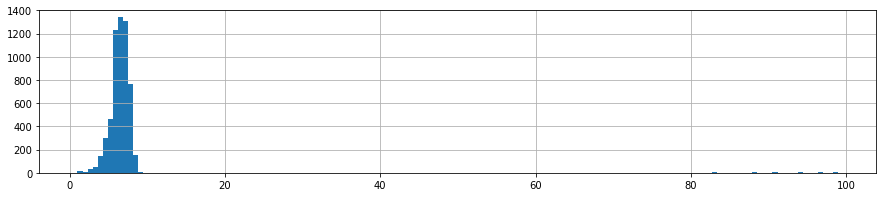

In [83]:
# Посмотрим на выбросы в рейтинге
df.ratings.hist(bins = 150, figsize = (15,3));

Видим, что большая часть оценок до **10** – это стандартная шкала оценивания фильмов. Но есть выбросы, которые больше этой шкалы.

Сначала было предположение, что тут используется просто стобалльная система оценивания и можно эту оценку просто поделить на **10**, но подозрения вызвали фильмы с оценкой **99**. Такого почти никогда не было. Проверив строки с высоким рейтингом, оказалось, что в реальности рейтинг у этих фильмов намного ниже, поэтому эти числа означают что-то другое. Их всего **29** штук.

In [84]:
df.query('ratings > 10 and not box_office.isna() and production_country == "Россия"')

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,have_duplicates,first_date,film_studio_sep
636,От винта!,114000212,2012-08-06 12:00:00,Анимационный,"ЗАО ""Продюсерский центр ""Парадиз""",Россия,О.Лопато,"Г.Нерсисян, А.Манасарян, А.Нерсесян",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,28.0,"детский,приключения,комедия",1740.0,False,both,"ЗАО ""Продюсерский центр ""Парадиз"
1535,Спираль.,111001014,2014-01-30 12:00:00,Художественный,"ООО ""Компания Питон""",Россия,А.Волгин,Е.Ковалева,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,99.0,"аниме,мультфильм,ужасы",4295.0,False,both,Компания Питон
1833,Поездка к матери,111002015,2015-03-02 12:00:00,Художественный,"ЗАО ""Киностудия ""М""-Фильм""",Россия,М.Косырев-Нестеров,М.Косырев-Нестеров,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,91.0,"драма,семейный",0.0,False,both,"Киностудия ""М""-Фильм"
1853,Главный,111003415,2015-03-27 12:00:00,Художественный,"ООО ""Киностудия ""МАСТЕР""",Россия,Ю.Кара,Ю.Кара,«6+» - для детей старше 6 лет,0.0,10000000.0,40000000.0,Министерство культуры,94.0,"фантастика,боевик,комедия",334750.0,False,both,"ООО ""Киностудия ""МАСТЕР"
2758,Я умею вязать,111019615,2015-11-27 12:00:00,Художественный,"ООО ""Белое Зеркало""",Россия,Н.Степанова при участии С.Иванова,"С.Кикнавелидзе, Д.Улюкаев",«16+» - для детей старше 16 лет,0.0,4700000.0,14462464.0,Министерство культуры,90.0,драма,801370.0,False,both,Белое Зеркало
3391,Охотники,111017816,2016-02-06 12:00:00,Художественный,Селиверстов Александр Александрович,Россия,А.Селиверстов,"Е.Тарковская, Т.Лагода, Д.Степанян",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,89.0,"фантастика,комедия,боевик",82840.0,False,both,Селиверстов Александр Александрович
6064,Колесо времени,111003219,2019-03-01 12:00:00,Художественный,"ООО ""БестМедиа""",Россия,Б.Куломзин,Б.Куломзин,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,98.0,"фэнтези,приключения",34992.0,False,both,БестМедиа
6476,Анна Каренина. Интимный дневник,111013919,2019-10-23 12:00:00,Художественный,"ООО ""РТВ""",Россия,Ю.Грымов,Ю.Грымов,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,79.0,драма,182882.5,False,both,РТВ


Проставим вручную рейтинг только тем записям, у которых есть информация о выручке и снятых в России. Таких записей всего 8:

In [85]:
df.loc[df['title'] == 'От винта!', 'ratings'] = 3.3
df.loc[df['title'] == 'Спираль.', 'ratings'] = 5
df.loc[df['title'] == 'Главный', 'ratings'] = 5.8

Заполнить удалось всего 3 фильма, остальные из списка реально не имеют рейтинг.

Остальным значениями поставим просто nan – т.к. рейтинга у них нет

In [86]:
# ставим NaN значениям больше 10
df.loc[df['ratings'] > 10, 'ratings'] = np.NaN

**Вывод:**

С числовыми переменными мы заполнили некорректные значения исходя из логики, что общий бюджет не может быть меньше, чем сумма гос. Поддержки. 

Причин, по которым могли возникнуть такие записи много придумать много, точно сказать трудно почему так вышло. Может при заполнении предполагалось что это поле означает бюджет без поддержки.

Также, мы избавились от аномально веского рейтинга, заменив значения выше стандартной оценки, значениями NaN.

У картин, где был высокий рейтинг (более 10), судя по КиноПоиску, этих данных вообще нет. Скорее всего эти числа означают что-то другое.

#### Шаг 2.6. Добавьте новые столбцы





- Создайте столбец с информацией о годе проката. Выделите год из даты премьеры фильма.

In [87]:
# создаем столбце с годом
df['year'] = df['show_start_date'].dt.year

- Создайте два столбца: с именем и фамилией главного режиссёра и основным жанром фильма. В столбцы войдут первые значения из списка режиссёров и жанров соответственно.

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_2" aria-expanded="false" aria-controls="collapseHint_2">Подсказка</button>
        </div>
        <div id="collapseHint_2" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Чтобы создать такие столбцы, лучше всего использовать собственную функцию. Эту функцию можно применить к двум столбцам сразу. 
            </div>
        </div>
    </div>
</div>

In [88]:
# Функция для получения первого текста до запятой
def get_main_name(text):
    if type(text) == str:
        full_name = text.split(',')[0]
        return full_name
    else:
        return text

In [89]:
# Применяем к двум столбцам
df['director_main'] = df['director'].apply(get_main_name)
df['genre_main'] = df['genres'].apply(get_main_name)

- Посчитайте, какую долю от общего бюджета фильма составляет государственная поддержка.

In [90]:
# считаем долю гос поддержки
df['part_budget_support'] = (df.refundable_support + df.nonrefundable_support) / df.budget

In [91]:
df[~df['part_budget_support'].isna()][['title', 'refundable_support', 'nonrefundable_support', 'budget', 'part_budget_support']].head(3)

,title,refundable_support,nonrefundable_support,budget,part_budget_support
1060,Пока еще жива,0.0,26500000.0,79411900.0,0.333703
1211,Бесславные придурки,0.0,26000000.0,37142857.0,0.700000
1256,Невидимки,0.0,107847945.0,176023490.0,0.612691


**Вывод:** Добавили все столбцы указанные в задании

### Шаг 3. Проведите исследовательский анализ данных


- Посмотрите, сколько фильмов выходило в прокат каждый год. Обратите внимание, что данные о прокате в кинотеатрах известны не для всех фильмов. Посчитайте, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах.

In [92]:
# Общее количество фильмов по годам
pivot_by_year = df.pivot_table(index='year', values='puNumber', aggfunc='count').rename(columns={'puNumber':'all'}).join(
            df.query('not box_office.isna()').pivot_table(index='year', values='puNumber', aggfunc='count')
                .rename(columns={'puNumber':'with_box'}))
pivot_by_year['part_with_box'] = pivot_by_year['with_box'] / pivot_by_year['all'] 
pivot_by_year.T

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
all,815.000000,525.000000,537.000000,598.000000,740.000000,649.00000,645.000000,494.000000,881.00000,909.000000
with_box,260.000000,182.000000,179.000000,212.000000,310.000000,469.00000,504.000000,356.000000,481.00000,533.000000
part_with_box,0.319018,0.346667,0.333333,0.354515,0.418919,0.72265,0.781395,0.720648,0.54597,0.586359


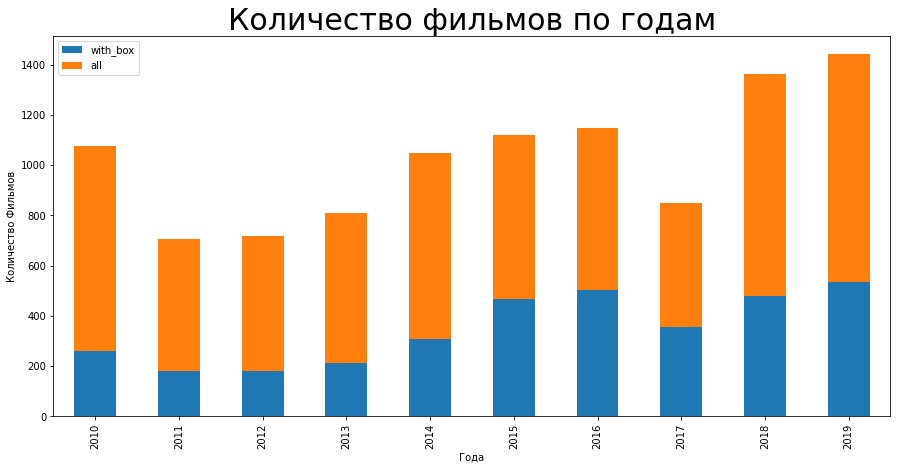

In [93]:
_,ax = plt.subplots()
ax = pivot_by_year[['with_box', 'all']].plot.bar(stacked=True, figsize=(15,7), 
                                            xlabel='Года', ylabel='Количество Фильмов' 
                                            , ax=ax)

ax.set_title('Количество фильмов по годам', fontsize = 30)
plt.show()

In [94]:
# общая доля пропусков в прокате
round(len(df[~df['box_office'].isna()]) / len(df), 2)

0.51

По данной сводной таблице видим, что больше всего фильмов было в **2019** году – **909** картин. Из-за такого большого объема, довольно много и картин, у которых есть информация о прокате. Но если говорить о соотношении, то самая большая доля картин с информацией о сборах есть в **2016** году - **0.75**, их количество **504**.

А общая доля картин с информацией о прокате составляет **51%**

- Изучите, как менялась динамика проката по годам. В каком году сумма сборов была минимальной? А максимальной?

In [95]:
(df.pivot_table(index='year', values='box_office', aggfunc='sum').reset_index()
     .astype('int').set_index('year').sort_values(by='box_office').T)

year,2012,2010,2011,2013,2014,2015,2016,2019,2017,2018
box_office,7003393,9880752,15067745,29823546,7444952609,39497528234,47860169239,48425708779,48561185043,49668403134


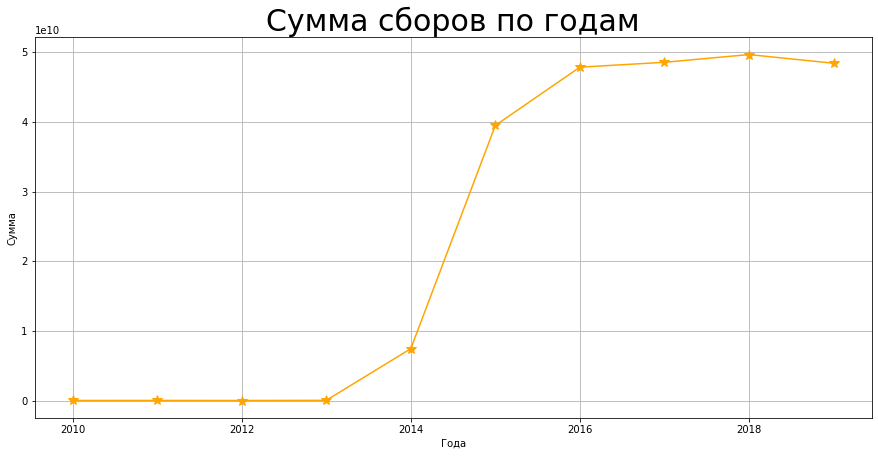

In [96]:
_,ax = plt.subplots()

ax = (df.pivot_table(index='year', values='box_office', aggfunc='sum')
        .plot(grid=True, color='orange', style="*-", markersize = 10, 
              legend=False, xlabel='Года', ylabel='Сумма', figsize=(15,7), ax=ax))
      
ax.set_title('Сумма сборов по годам', fontsize = 30)
plt.show()

Как видно на графике – самый прибыльный год был **2018**. За него собрали **49 миллиардов**.

А меньше всего сборов было в **2012** году, всего **7 миллионов**.

- С помощью сводной таблицы посчитайте среднюю и медианную сумму сборов для каждого года.

In [97]:
df.pivot_table(index='year', values='box_office', aggfunc=['mean', 'median']).T.style.format("{:,.0f}")

,year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
mean,box_office,"38,003","82,790","39,125","140,677","24,015,976","84,216,478","94,960,653","136,407,823","103,260,713","90,854,988"
median,box_office,0,478,"1,070","2,355","13,195","4,784,782","4,657,726","10,177,834","8,688,968","4,554,745"


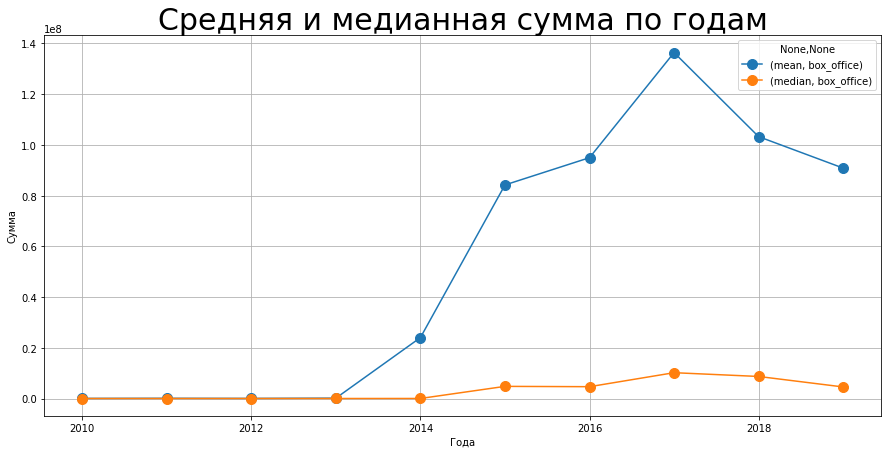

In [98]:
_,ax = plt.subplots()

ax = (df.pivot_table(index='year', values='box_office', aggfunc=['mean', 'median'])
        .plot(grid=True, style="o-", markersize = 10, 
            xlabel='Года', ylabel='Сумма', figsize=(15,7), ax=ax))
      
ax.set_title('Cредняя и медианная сумма по годам', fontsize = 30)
plt.show()

Как видно на графике, с 2013 года среднее и медиана сильно отличаются. Скорее всего, в эти годы были очень популярные фильмы, которые собрали гигантскую кассу, что и сильно повиляло на среднее значение, однако медиана по всем годам стабильная.

- Определите, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год? Фильмы с каким возрастным ограничением собрали больше всего денег в прокате? Меняется ли картина в зависимости от года? Если да, предположите, с чем это может быть связано.

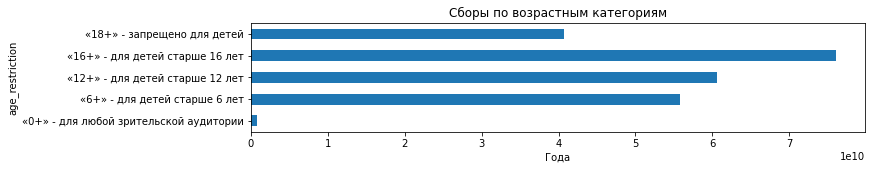

In [99]:
_, ax = plt.subplots(figsize = (10,5))

ax = (df[df['year']>2014].pivot_table(index='age_restriction', values='box_office', aggfunc=['sum'])
    .plot.barh(ax=ax, figsize=(11,2), legend=False))
ax.set_xlabel('Года')
ax.set_title('Сборы по возрастным категориям')
plt.show()

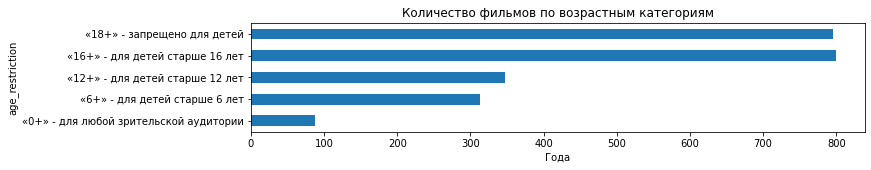

In [100]:
_, ax = plt.subplots(figsize = (10,5))

ax = (df[df['year']>2014].pivot_table(index='age_restriction', values='box_office', aggfunc=['count'])
    .plot.barh(ax=ax, figsize=(11,2), legend=False))
ax.set_xlabel('Года')
ax.set_title('Количество фильмов по возрастным категориям')
plt.show()

На графике с количеством видно, что картин 18+ снимают примерно столько-же, сколько и 16+, однако фильмы 18+ находятся на предпоследнем месте по собранной выручке.

Насчет таких мест в рейтинге есть гипотеза, подкрепленная жизненным опытом. Когда я находился в возрасте от 12 до 18 лет я посещал кинотеатр намного чаще, чем после 18. В первую очередь это связано с тем, что в более взрослом возрасте свободного времени становится намного меньше

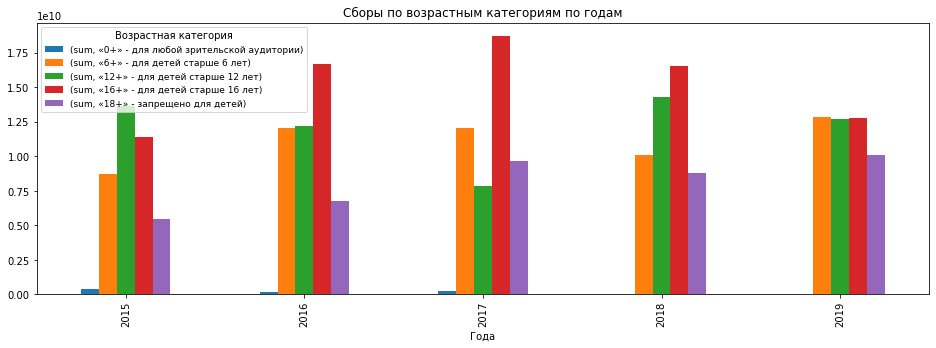

In [101]:
_, ax = plt.subplots(figsize = (17,5))

ax = (df[df['year']>2014].pivot_table(index='year', columns='age_restriction', values='box_office', aggfunc=['sum'])
    .plot.bar(ax=ax, figsize=(16,5)))
ax.set_xlabel('Года')
ax.legend(loc = 'upper left', title = 'Возрастная категория', fontsize = 9)
ax.set_title('Сборы по возрастным категориям по годам')
plt.show()

Самые большие сборы были у категории 16+ с 2016 по 2018 годы, однако в 2015 году большую кассу собрали картины 12+, а в 2019 году категории с 6+ до 16+ стоят почти на ровне

Скорее всего такое распределение по годам и рейтингу связано с выходом продолжений культовых блокбастеров, у которых стоят такие возрастные категории:
- в 2015 году выходили Миньоны и Монстры на каникулах 2. У них рейтинг 6+, отсюда такие высокие показатели
- в 2016 году были популярные супергеройские фильмы: Отряд самоубийц и Доктор Стрэндж с рейтингом 16+
- в 2017: Тор: Рагнарёк, Стражи Галактики. Часть 2
- в 2018: Веном, Мстители: Война бесконечности, Полицейский с рублевки. Новогодний беспредел
- в 2019 были популярные фильмы из разных категорий, и распределены они равномерно, вот самые популярные представители: Холоп (12+), Мстители: Финал (16+), Малефисента (6+), Джокер (18+)

Следовательно, такое распределение зависит от выхода фильмов из популярных киновселенных, например таких как Marvel, DC, продолжение культовых серий, таких как Миньоны, монстры на каникулах и т.д. У таких фильмов стоят определенные возрастные рейтинги, из-за чего этот параметр в таблице возрастает

### Шаг 4. Исследуйте фильмы, которые получили государственную поддержку

На этом этапе нет конкретных инструкций и заданий — поищите интересные закономерности в данных. Посмотрите, сколько выделяют средств на поддержку кино. Проверьте, хорошо ли окупаются такие фильмы, какой у них рейтинг.

Для начала вычислим, сколько чистой прибыли собрали фильмы, чтобы можно было судить, окупилась картина или нет:

In [102]:
# Вычислим чистую прибыль
df['net_profit'] = df['box_office'] - df['budget']

In [103]:
# Сделаем пометку к фильмам с гос. поддержкой
df['gos_support'] = df['part_budget_support'] > 0

In [104]:
# Выдели столбцы для анализа
analysis_columns = ['title','year', 'genre_main', 
                    'director_main', 'age_restriction', 
                    'budget', 'ratings', 
                    'part_budget_support', 'net_profit']

In [105]:
# Включим полный вывод чисел без научной нотации
pd.options.display.float_format = '{:20,.2f}'.format

In [106]:
# Посмотрим топ 5 самых окупаемых фильмов 
df.query('gos_support').sort_values(by='net_profit', ascending=False)[analysis_columns].head(5)

,title,year,genre_main,director_main,age_restriction,budget,ratings,part_budget_support,net_profit
6763,Холоп,2019,комедия,К.Шипенко,«12+» - для детей старше 12 лет,"160,000,000.00",6.80,0.38,"2,913,568,690.79"
4991,Движение вверх,2017,спорт,А.Мегердичев,«6+» - для детей старше 6 лет,"590,192,191.00",7.50,0.68,"2,189,493,953.00"
5878,Т-34,2018,драма,А.Сидоров,«12+» - для детей старше 12 лет,"563,784,717.00",6.50,0.32,"1,707,969,287.52"
4843,Последний богатырь,2017,комедия,Д.Дьяченко,«12+» - для детей старше 12 лет,"352,477,575.00",6.80,0.28,"1,302,560,113.00"
5046,Лёд,2018,NaN,О.Трофим,«12+» - для детей старше 12 лет,"148,585,222.00",NaN,0.57,"1,297,146,575.89"


Как видно, самые большие сборы были у фильма холоп, чистая прибыль составила около 3х миллиардов, при затратах всего в 160 млн

Посмотрим сколько государство выделяло поддержки в каждом году. Для это создадим еще один столбец, который будет отвечать за сумму гос. поддержки:

In [107]:
# Вычисляем сумму гос поддержки
df['full_gos_support'] = df['refundable_support'] + df['nonrefundable_support']

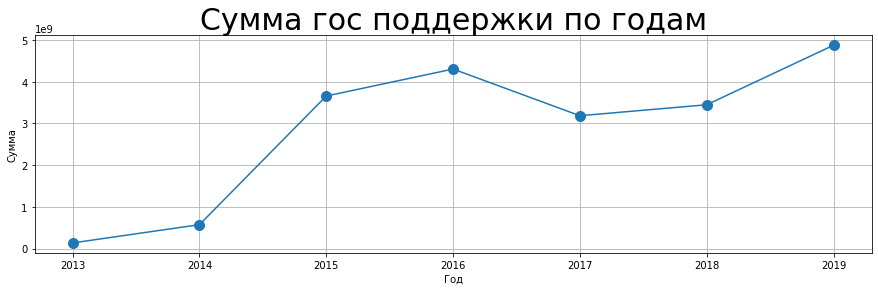

In [108]:
_,ax = plt.subplots()

ax = (df.query('gos_support and year > 2012').pivot_table(index='year', values='full_gos_support', aggfunc=['sum'])
        .plot(grid=True, style="o-", markersize = 10, 
            ylabel='Сумма', xlabel='Год', figsize=(15,4), legend=False, ax=ax))
      
ax.set_title('Сумма гос поддержки по годам', fontsize = 30)
plt.show()

In [109]:
df.query('gos_support and year > 2012').pivot_table(index='year', values='full_gos_support', aggfunc=['sum']).T.style.format("{:,.0f}")

,year,2013,2014,2015,2016,2017,2018,2019
sum,full_gos_support,"134,347,945","572,002,299","3,656,241,459","4,303,155,482","3,183,971,662","3,446,969,465","4,874,000,000"


Самое большое финансирование было в **2019** году: почти **5 млр** рублей.

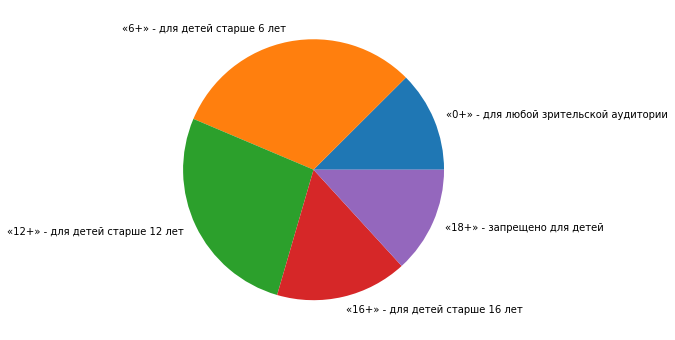

In [110]:
# Поддержка по возрастным категориям
df.pivot_table(columns='age_restriction', values='full_gos_support').T['full_gos_support'].plot.pie(figsize=(6, 6), ylabel=' ');

In [111]:
df.query('gos_support').pivot_table(index='age_restriction', values='ratings').sort_values(by='ratings', ascending=False).T

age_restriction,«0+» - для любой зрительской аудитории,«18+» - запрещено для детей,«12+» - для детей старше 12 лет,«16+» - для детей старше 16 лет,«6+» - для детей старше 6 лет
ratings,6.41,6.27,6.04,5.93,5.91


Большая часть поддержки была выделена на проекты с рейтингом 6+ и 12+, при этом оценки у этих категорий, в среднем не сильно высокие

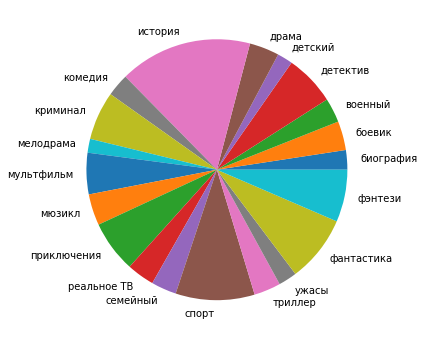

In [112]:
# Поддержка по жанрам
df.pivot_table(columns='genre_main', values='full_gos_support').T['full_gos_support'].plot.pie(figsize=(6, 6), ylabel=' ');

In [113]:
df.query('gos_support').pivot_table(index='genre_main', values='ratings').sort_values(by='ratings', ascending=False).head(10).T

genre_main,криминал,детский,спорт,биография,детектив,боевик,мюзикл,военный,драма,фэнтези
ratings,7.50,7.12,6.93,6.90,6.76,6.58,6.55,6.47,6.39,6.17


По жанрам у нас больше всего финансируются исторические фильмы. После них идут спорт и фантастика.

А самые лучшие оценки стоят у фильмов в жаре криминал, детский и спорт

Проверим, окупаемость финансируемых фильмов за каждый год

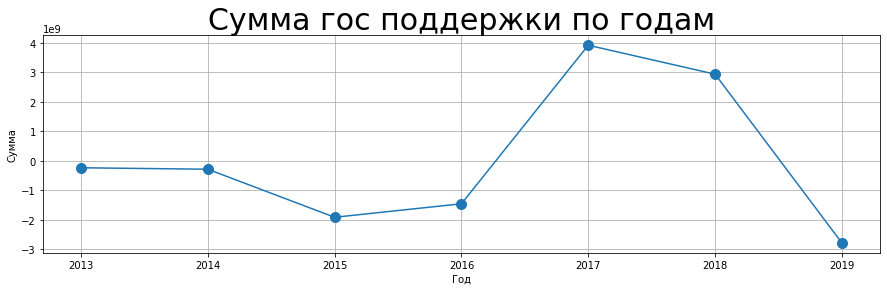

In [114]:
_,ax = plt.subplots()

ax = (df.query('gos_support and year > 2012').pivot_table(index='year', values='net_profit', aggfunc=['sum'])
        .plot(grid=True, style="o-", markersize = 10, 
            ylabel='Сумма', xlabel='Год', figsize=(15,4), legend=False, ax=ax))
      
ax.set_title('Сумма гос поддержки по годам', fontsize = 30)
plt.show()

In [115]:
df.query('gos_support and year > 2012').pivot_table(index='year', values='net_profit', aggfunc=['sum']).T.style.format("{:,.0f}")

,year,2013,2014,2015,2016,2017,2018,2019
sum,net_profit,"-235,113,005","-285,062,616","-1,911,384,805","-1,454,528,829","3,913,502,733","2,933,404,911","-2,779,704,821"


Судя по годам, вложенные средства чаще не окупались, однако в 2017 и 2018 был сильный пик, который окупил все вложения. Скорее всего, такой пик вызван самыми популярными фильмами, которые есть даже в топ 5: Движение вверх, Т-34, последний богатырь, Лёд. Эти фильмы как раз за 2017-2018 год.

Посмотрим на связь числительных переменных друг с другом:

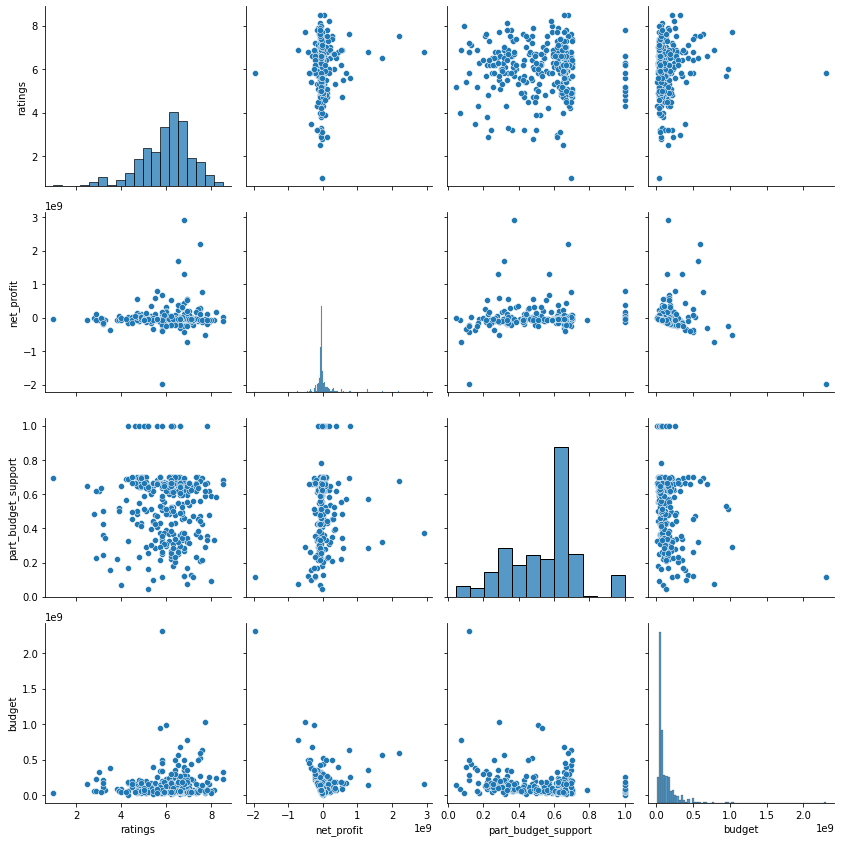

In [116]:
sns.pairplot(df.query('gos_support')[['ratings', 'net_profit', 'part_budget_support', 'budget']])
plt.gcf().set_size_inches(12,12);

Как видно из графиков, нигде четкой корреляции не прослеживается.
Связь рейтинг и бюджета, хоть и не сильная, но есть: фильмы с бюджетом более 500 млн получают оценку не менее 5, но в целом вложенные деньги не означают положительные оценки и окупаемость.

In [117]:
(df.query('gos_support and not net_profit.isna()')
    .pivot_table(index=['director_main'], values=['net_profit', 'part_budget_support', 'ratings'], aggfunc='mean').sort_values(by='net_profit', ascending=False))

,net_profit,part_budget_support,ratings
director_main,,,
А.Мегердичев,"2,189,493,953.00",0.68,7.50
А.Сидоров,"1,707,969,287.52",0.32,6.50
О.Трофим,"1,297,146,575.89",0.57,NaN
К.Шипенко,"1,040,947,183.26",0.45,6.83
Ф.Бондарчук,"788,321,489.00",1.00,5.60
...,...,...,...
И.Зайцев,"-361,663,692.47",0.26,5.80
А.Мельник,"-427,421,682.60",0.12,6.80
А.Учитель,"-521,130,409.00",0.29,7.70


Самыми прибыльными режиссёрами оказали авторы фильмов, которые вошли в топ 5 (Лед, Т-34, Движение Вверх…), гос. поддержка у него в районе от 30% до 60%

Есть также Федор Бондарчук. Бюджет его фильмов полностью на гос. поддержке, при этом он принес хороший результат.

### Шаг 5. Напишите общий вывод

В процессе работы над проектом, были освоены новые технологии, для борьбы с проблемными данными. В таблице есть множество пропусков, поэтому множество картин пришлось отбросить.

Мы попытались обработать все проблемы, с которыми столкнулись, не все удалось решить должным образом. Например, от неявных дублей в категориальных значениях так и не удалось избавиться, однако были освоены новые технологи, которые немного упрощают эту задачу.

Как выяснилось, нет точной формулы для создания идеального фильма. Картина не обязательно окупится и получит хорошие оценки даже если вложить в нее много денег.

Тут многое зависит от удачи, или есть какие-то скрытые переменные, которые в итоге будут влиять на итоговую оценку.
Почти на все фильмы, которые были в топе я ходил. Не могу сказать, что часто посещаю кино, или меня сильно привлекли эти фильмы рекламой, но по стечению обстоятельств я в итоге побывал на них. Скорее всего есть какие-то скрытые обстоятельства, которые влияют на успех картины, но, чтобы это понять нужно больше различных данных  

Также, в ходе исследования были выявлены следующие статистические данные:
- Больше всего денег принес фильм Холоп – около 3х миллиардов при бюджете 160 миллионов
- Гос. поддержка фильмов составляет в среднем 60 млн, а по медиане 35 млн
- Самые лучшие показатели у режиссёра Антона Мегердичева, который работал над Движение вверх, который принес 2 миллиарда и рейтинг 7.5.
- Самыми высоко оцениваемыми жанрами у нас являются криминал и спорт, а также детские фильмы
- Самый провальный фильм Тайна Печати Дракона. При бюджете в 2,3 миллиарда он смог собрать всего 333 миллиона
- 2017 и 2018 года были самыми лучшими. Вышло немало фильмов, которые смогли отбить все затраты

### Чек-лист готовности проекта


- [x] 1.Откройте файлы с данными и объедините их в один датафрейм
- [x] 2.Предобработка данных
    - [x] 2.1.Проверьте типы данных в датафрейме и преобразуйте там, где это необходимо
    - [x] 2.2.Изучите пропуски в датафрейме. Объясните, почему заполнили пропуски определённым образом или почему не стали это делать.
    - [x] 2.3.Проверьте, есть ли в данных дубликаты. Опишите причины, которые могли повлиять на появление дублей.
    - [x] 2.4.Изучите столбцы, которые содержат категориальные значения:
        - [x] 2.4.1.Посмотрите, какая общая проблема встречается почти во всех категориальных столбцах.
        - [x] 2.4.2.Исправьте проблемные значения в поле type.
    - [x] 2.5.Изучите столбцы, которые хранят количественные значения. Проверьте, обнаружились ли в таких столбцах подозрительные данные. Как с такими данными лучше поступить?
    - [x] 2.6.Добавьте новые столбцы:
        - [x] 2.6.1.Создайте столбец с информацией о годе проката. Выделите год из даты премьеры фильма.
        - [x] 2.6.2.Создайте два столбца: с именем и фамилией главного режиссёра и основным жанром фильма. В столбцы войдут первые значения из списка режиссёров и жанров соответственно.
        - [x] 2.6.3.Посчитайте, какую долю от общего бюджета фильма составляет государственная поддержка.
- [x] 3.Проведите исследовательский анализ данных
    - [x] 3.1.Посмотрите, сколько фильмов выходило в прокат каждый год. Обратите внимание, что данные о прокате в кинотеатрах известны не для всех фильмов. Посчитайте, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах. Проанализируйте, как эта доля менялась по годам. Сделайте вывод о том, какой период полнее всего представлен в данных.
    - [x] 3.2.Изучите, как менялась динамика проката по годам. В каком году сумма сборов была минимальной? А максимальной?
    - [x] 3.3.С помощью сводной таблицы посчитайте среднюю и медианную сумму сборов для каждого года. Сравните значения и сделайте выводы.
    - [x] 3.4.Определите, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год? Фильмы с каким возрастным ограничением собрали больше всего денег в прокате? Меняется ли картина в зависимости от года? Если да, предположите, с чем это может быть связано.
- [x] 4.Исследуйте фильмы, которые получили государственную поддержку
- [x] 5.Напишите общий вывод

### Настройки проекта

In [118]:
# Отключим ограничение на количество выводимых строк
pd.set_option('max_rows', None)

In [119]:
# Ширина строк
pd.set_option('display.max_colwidth', None)

In [120]:
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [121]:
# Включим полный вывод чисел без научной нотации
pd.options.display.float_format = '{:20,.2f}'.format

In [122]:
# Включим полный вывод чисел без научной нотации
pd.options.display.float_format = None

In [123]:
# Сбросим опцию
pd.reset_option('max_rows')
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_columns')
pd.reset_option('display.float_format')